In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import numpy as np
import us
import json 

In [51]:
# Load the csv file
insurance_df = pd.read_csv("Resources/insurance.csv")

# Load xlsx file
cms_df = pd.read_excel("Resources/CMS-2021-Data.xlsx")

In [3]:
# Inspect DataFrame to ensure it loaded correctly by displaying first 5 rows
print("Insurance Data:")
print(insurance_df.head())

print("\nCMS 2021 Data:")
print(cms_df.head())

# Check column names and data types
print("\nInsurance Data Info:")
print(insurance_df.info())

print("\nCMS 2021 Data Info:")
print(cms_df.info())

Insurance Data:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

CMS 2021 Data:
  State  Issuer_ID                                       Issuer_Name  \
0    AK      38344          Premera Blue Cross Blue Shield of Alaska   
1    AK      77963                            Moda Assurance Company   
2    AL      46944             Blue Cross and Blue Shield of Alabama   
3    AL      73301                   Bright Health Insurance Company   
4    AR      37903  QualChoice Life & Health Insurance Company, Inc.   

  Is_Issuer_New_to_Exchange  Claims_Received  Claims_Denials  Denial_Rate  \
0                        No           603348          143208        0.237 

In [4]:
# Connect to a new SQLite database
conn = sqlite3.connect("insurance.db")

In [5]:
# Load DataFrames into SQLite tables
insurance_df.to_sql("insurance", conn, if_exists="replace", index=False)
cms_df.to_sql("cms_2021_data", conn, if_exists="replace", index=False)

162

In [6]:
## Verify Data in SQLite loaded correctly 
# Create cursor object 
cursor = conn.cursor()

# Query insurance table
cursor.execute("SELECT * From insurance LIMIT 5")
print("/nCMS 2021 Data Tables:")
for row in cursor.fetchall():
    print (row)

/nCMS 2021 Data Tables:
(19, 'female', 27.9, 0, 'yes', 'southwest', 16884.924)
(18, 'male', 33.77, 1, 'no', 'southeast', 1725.5523)
(28, 'male', 33.0, 3, 'no', 'southeast', 4449.462)
(33, 'male', 22.705, 0, 'no', 'northwest', 21984.47061)
(32, 'male', 28.88, 0, 'no', 'northwest', 3866.8552)


In [7]:
# Close connection 
# conn.close()

In [8]:
## 1.	How do claim charges vary by demographic factors (age, sex, BMI, smoking status, and region)?

In [9]:
# Connect database
conn = sqlite3.connect("insurance.db")

In [10]:
# Average claim charges by age, sex, and region
query = """
SELECT age, sex, region, bmi, smoker, AVG(charges) AS avg_claim_charges
FROM insurance 
Group By age, sex, region, bmi, smoker
"""

df = pd.read_sql(query, conn)
print(df)

      age     sex     region     bmi smoker  avg_claim_charges
0      18  female  northeast  21.660    yes       14283.459400
1      18  female  northeast  25.080     no        2196.473200
2      18  female  northeast  26.315     no        2198.189850
3      18  female  northeast  28.215     no        2200.830850
4      18  female  northeast  29.165     no        7323.734819
...   ...     ...        ...     ...    ...                ...
1325   64    male  southeast  36.960    yes       49577.662400
1326   64    male  southeast  39.160     no       14418.280400
1327   64    male  southeast  40.480     no       13831.115200
1328   64    male  southwest  25.600     no       14988.432000
1329   64    male  southwest  34.500     no       13822.803000

[1330 rows x 6 columns]


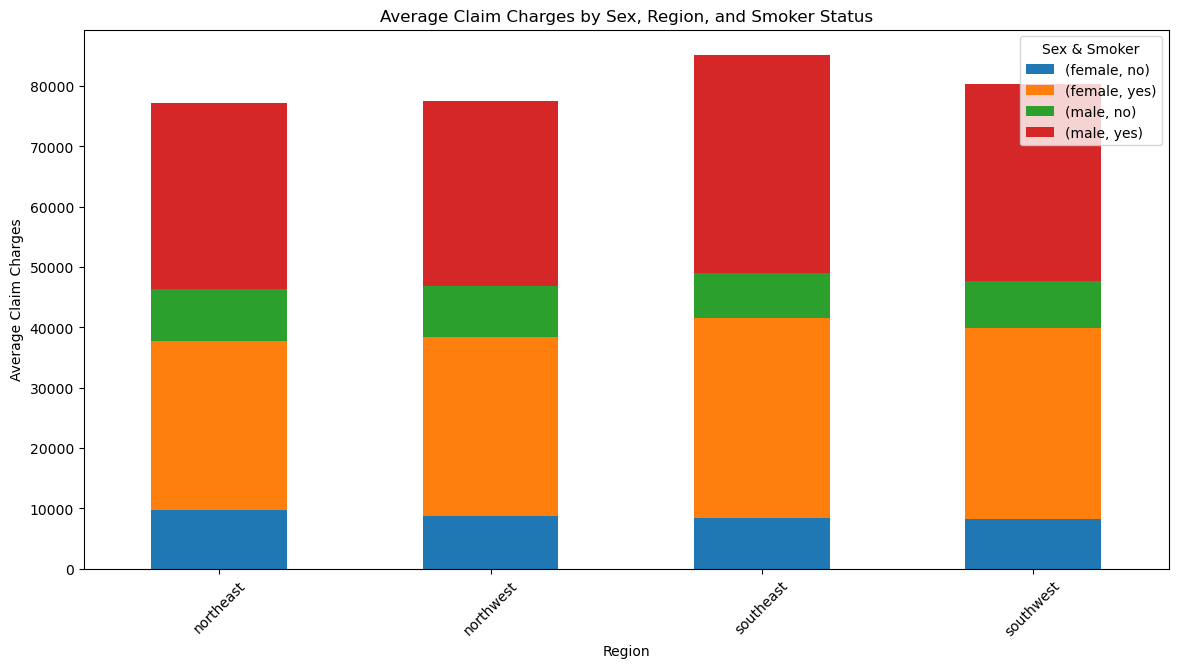

In [11]:
# Pivot the table for better visualization
df_pivot = df.pivot_table(index=['region'], columns=['sex', 'smoker'], values='avg_claim_charges')

# Plot stacked bar chart
df_pivot.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Average Claim Charges by Sex, Region, and Smoker Status')
plt.xlabel('Region')
plt.ylabel('Average Claim Charges')
plt.legend(title="Sex & Smoker")
plt.xticks(rotation=45)
plt.show()

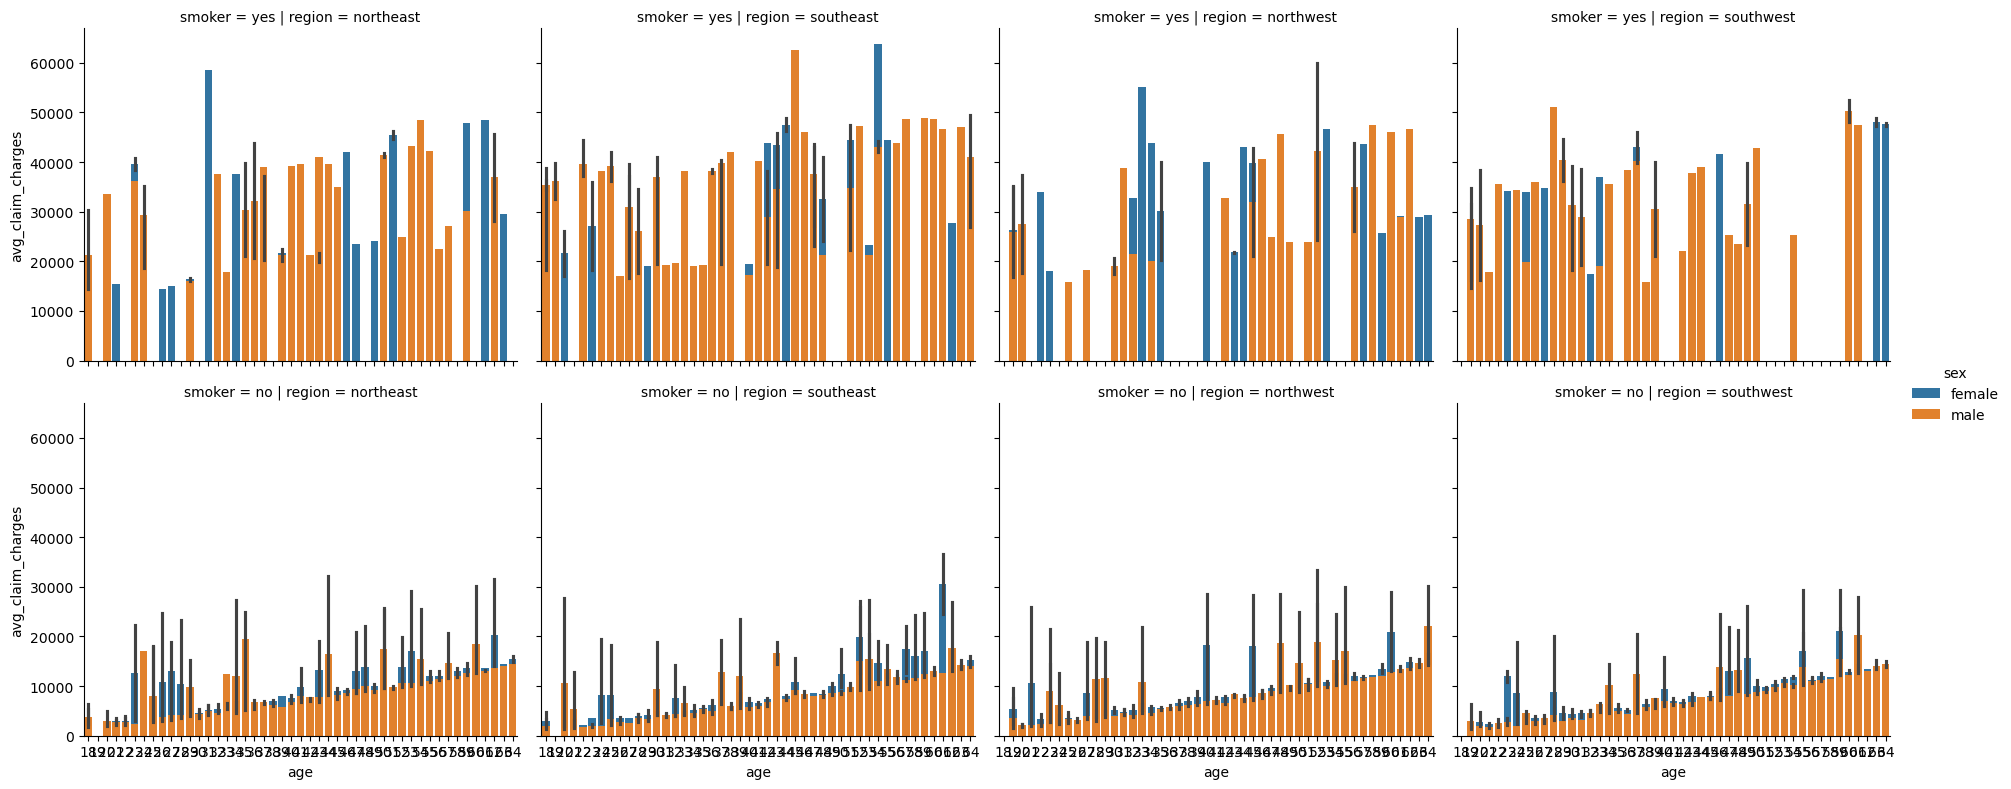

In [12]:
# Create a FacetGrid (small multiple graphs by region)
g = sns.FacetGrid(df, col="region", row="smoker", hue="sex", height=4, aspect=1.2)
g.map(sns.barplot, "age", "avg_claim_charges", order=sorted(df['age'].unique()))
g.add_legend()
plt.show()

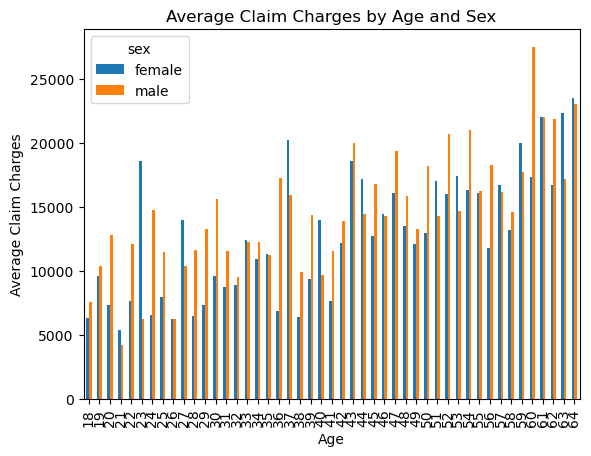

In [13]:
# Visualize Results with bar plot
df.pivot_table(index='age', columns='sex', values='avg_claim_charges').plot(kind='bar')
plt.title('Average Claim Charges by Age and Sex')
plt.xlabel('Age')
plt.ylabel('Average Claim Charges')
plt.show()

# conn.close()

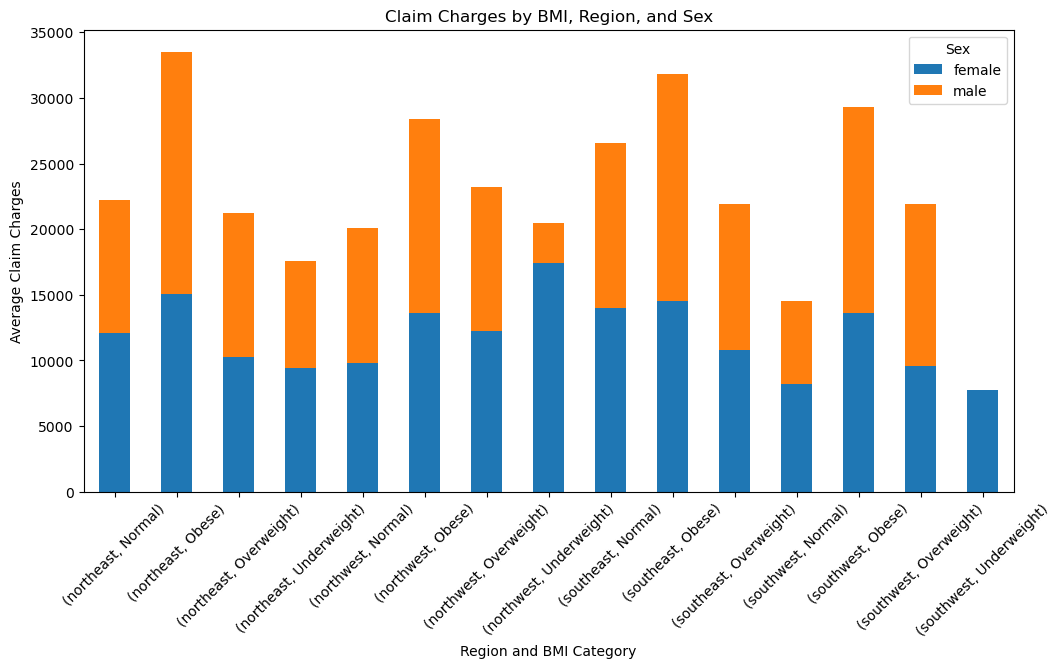

In [14]:
# Query insurance data grouped by BMI category, region, and sex
query = """
SELECT region, sex, 
       CASE 
           WHEN bmi < 18.5 THEN 'Underweight'
           WHEN bmi BETWEEN 18.5 AND 24.9 THEN 'Normal'
           WHEN bmi BETWEEN 25 AND 29.9 THEN 'Overweight'
           ELSE 'Obese'
       END AS BMI_Category,
       AVG(charges) AS avg_claim_charges
FROM insurance
GROUP BY region, sex, BMI_Category
"""

df = pd.read_sql(query, conn)

# Pivot data for stacked bar chart
df_pivot = df.pivot_table(index=['region', 'BMI_Category'], columns='sex', values='avg_claim_charges')

# Plot stacked bar chart
df_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Claim Charges by BMI, Region, and Sex')
plt.xlabel('Region and BMI Category')
plt.ylabel('Average Claim Charges')
plt.legend(title="Sex")
plt.xticks(rotation=45)
plt.show()

In [15]:
# 2. Which states or regions have the highest claim charges and denial rates, and how do they compare across regions?

In [16]:
# Query: Regions claim charges from highest to lowest
query = """
SELECT region, AVG(charges) as avg_claim_charges
FROM insurance
GROUP BY region
ORDER BY avg_claim_charges DESC
"""
df = pd.read_sql(query, conn)
print(df)

      region  avg_claim_charges
0  southeast       14735.411438
1  northeast       13406.384516
2  northwest       12417.575374
3  southwest       12346.937377


In [17]:
# Calculate average claim charges
region_claim_charges = insurance_df.groupby('region')['charges'].mean().reset_index()
region_claim_charges

,region,charges
0,northeast,13406.384516
1,northwest,12417.575374
2,southeast,14735.411438
3,southwest,12346.937377


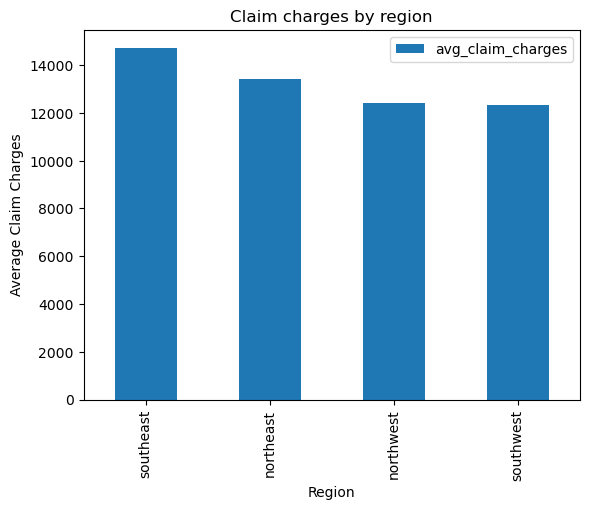

In [18]:
# Visualize Results with bar plot
df.plot(kind='bar', x='region', y='avg_claim_charges', title='Claim charges by region')
plt.xlabel('Region')
plt.ylabel('Average Claim Charges')
plt.show()

# conn.close()

In [19]:
## Top denial rates by state
# Sort data by denial rate in descending order
top_denial_states = cms_df.sort_values(by='Denial_Rate', ascending=False)

# Select the top 10 states with the highest denial rates
top_10_states = top_denial_states[['State', 'Denial_Rate']].head(10)

# Display the results
print('Top 10 States with the Highest Denial Rates;')
print(top_10_states)

Top 10 States with the Highest Denial Rates;
    State  Denial_Rate
61     MI        0.487
110    SC        0.483
38     IL        0.476
77     NC        0.452
119    TN        0.446
124    TX        0.435
140    VA        0.425
72     MS        0.425
95     OH        0.421
17     FL        0.419


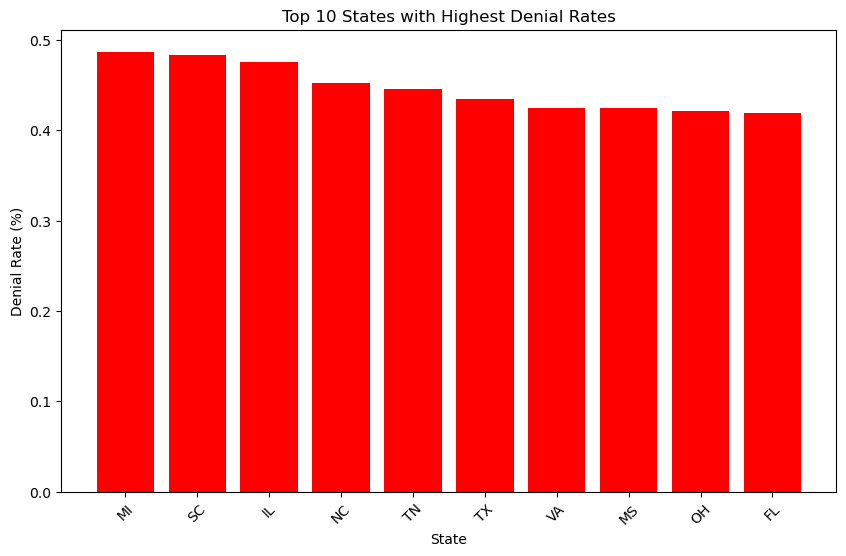

In [20]:
# Visualize Results 
plt.figure(figsize=(10,6))
plt.bar(top_10_states['State'], top_10_states['Denial_Rate'], color='red')
plt.title('Top 10 States with Highest Denial Rates')
plt.xlabel('State')
plt.ylabel('Denial Rate (%)')
plt.xticks(rotation=45)
plt.show()

In [21]:
## Map U.S. states by region

In [22]:
# All U.S. states and regions including abbreviations 
regions = { "Northeast": { "full_names": ["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", 
                                          "Connecticut", "New York", "New Jersey", "Pennsylvania"], 
                          "abbreviations": ["ME", "NH", "VT", "MA", "RI", "CT", "NY", "NJ", "PA"] }, 
           
           "Southeast": { "full_names": ["Delaware", "Maryland", "West Virginia", "Virginia", "Kentucky", 
                                         "North Carolina", "South Carolina", "Tennessee", "Georgia", "Florida", 
                                         "Alabama", "Mississippi", "Arkansas", "Louisiana"], 
                         "abbreviations": ["DE", "MD", "WV", "VA", "KY", "NC", "SC", "TN", "GA", "FL", 
                                           "AL", "MS", "AR", "LA"] }, 
           
           "Northwest": { "full_names": ["Washington", "Oregon", "Idaho", "Montana", "Wyoming", "Minnesota", 
                                         "North Dakota", "South Dakota", "Nebraska"], 
                         "abbreviations": ["WA", "OR", "ID", "MT", "WY", "MN", "ND", "SD", "NE"] }, 
           
           "Southwest": { "full_names": ["California", "Nevada", "Utah", "Colorado", "Arizona", "New Mexico", 
                                         "Texas", "Oklahoma", "Alaska", "Hawaii", "Kansas", "Missouri", "Iowa"], 
                         "abbreviations": ["CA", "NV", "UT", "CO", "AZ", "NM", "TX", "OK", "AK", "HI", "KS", "MO", "IA"] },
           "Midwest": { "full_names": ["Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin"], 
                       "abbreviations": ["IL", "IN", "MI", "OH", "WI"]} } 


In [23]:
# Function to get the region by state name or state abbreviation 
def get_region(state): 
    state = state.strip()  
    state_name = state.title()
    state_abbr = state.upper()
    for region, data in regions.items(): 
        if state in data["full_names"] or state in data["abbreviations"]: 
            return region 
    return "Unknown"  # Output for state not found
        
# Verify U.S. states and regions imported correctly 
print(get_region("Minnesota"))  # Output: Northwest 
print(get_region("MN"))  # Output: Northwest 
print(get_region("Florida"))  # Output: Southeast 
print(get_region("FL"))  # Output: Southeast 
print(get_region("California"))  # Output: Southwest 
print(get_region("CA"))  # Output: Southwest
print(get_region("New York"))  # Output: Northeast 
print(get_region("NY"))  # Output: Northeast
print(get_region("Wisconsin"))  # Output: Midwest
print(get_region("WI"))  # Output: Midwest

Northwest
Northwest
Southeast
Southeast
Southwest
Southwest
Northeast
Northeast
Midwest
Midwest


In [24]:
# Add region to CMS data
cms_df['region'] = cms_df['State'].apply(get_region)

In [25]:
# Verify regions are correctly assigned 
print(cms_df[['State', 'region']].drop_duplicates().head())

   State     region
0     AK  Southwest
2     AL  Southeast
4     AR  Southeast
9     AZ  Southwest
15    DE  Southeast


In [26]:
# print(cms_df.head())

In [27]:
print("Unique Regions in cms_df:") 
print(cms_df['region'].unique())

Unique Regions in cms_df:
['Southwest' 'Southeast' 'Midwest' 'Northwest' 'Northeast']


In [28]:
unknown_states = cms_df[cms_df['region'] == "Unknown"]['State'].unique() 
print("States with Unknown Region:") 
print(unknown_states)

States with Unknown Region:
[]


In [29]:
# Calculate average denial rates by region
region_denial_rates = cms_df.groupby('region')['Denial_Rate'].mean().reset_index()
print(region_denial_rates)

      region  Denial_Rate
0    Midwest     0.182098
1  Northeast     0.230000
2  Northwest     0.088944
3  Southeast     0.183582
4  Southwest     0.177822


In [30]:
print("Region Denial Rates:") 
print(region_denial_rates) 
print("\nRegion Claim Charges:") 
print(region_claim_charges)

Region Denial Rates:
      region  Denial_Rate
0    Midwest     0.182098
1  Northeast     0.230000
2  Northwest     0.088944
3  Southeast     0.183582
4  Southwest     0.177822

Region Claim Charges:
      region       charges
0  northeast  13406.384516
1  northwest  12417.575374
2  southeast  14735.411438
3  southwest  12346.937377


In [31]:
region_denial_rates

,region,Denial_Rate
0,Midwest,0.182098
1,Northeast,0.230000
2,Northwest,0.088944
3,Southeast,0.183582
4,Southwest,0.177822


In [32]:
region_claim_charges

,region,charges
0,northeast,13406.384516
1,northwest,12417.575374
2,southeast,14735.411438
3,southwest,12346.937377


<Figure size 1000x600 with 0 Axes>

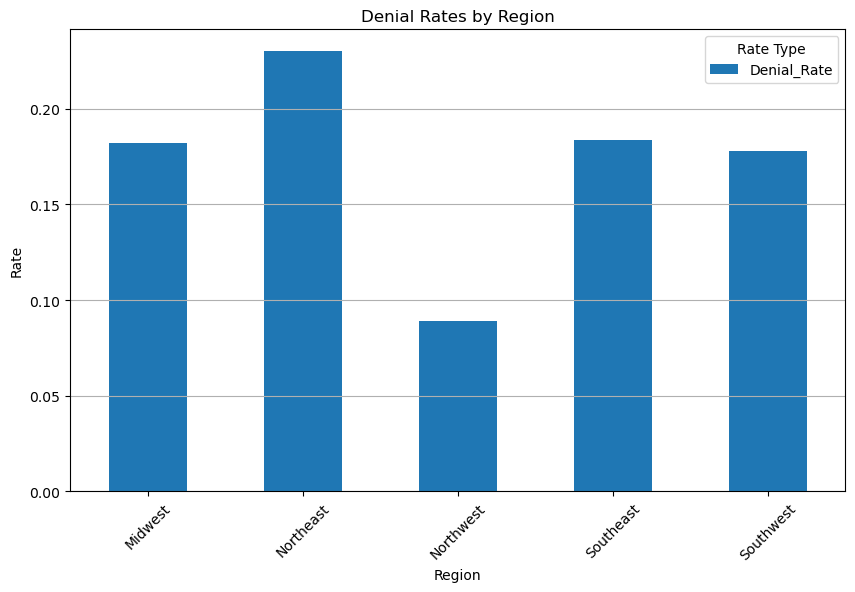

In [33]:
# Visualize Results 
plt.figure(figsize=(10, 6)) 
region_denial_rates.set_index('region').plot(kind='bar', figsize=(10, 6)) 

# Add labels and title
plt.xlabel('Region') 
plt.ylabel('Rate') 
plt.title('Denial Rates by Region') 
plt.legend(title='Rate Type') 
plt.xticks(rotation=45) 
plt.grid(axis='y')
plt.show()

<Figure size 1000x600 with 0 Axes>

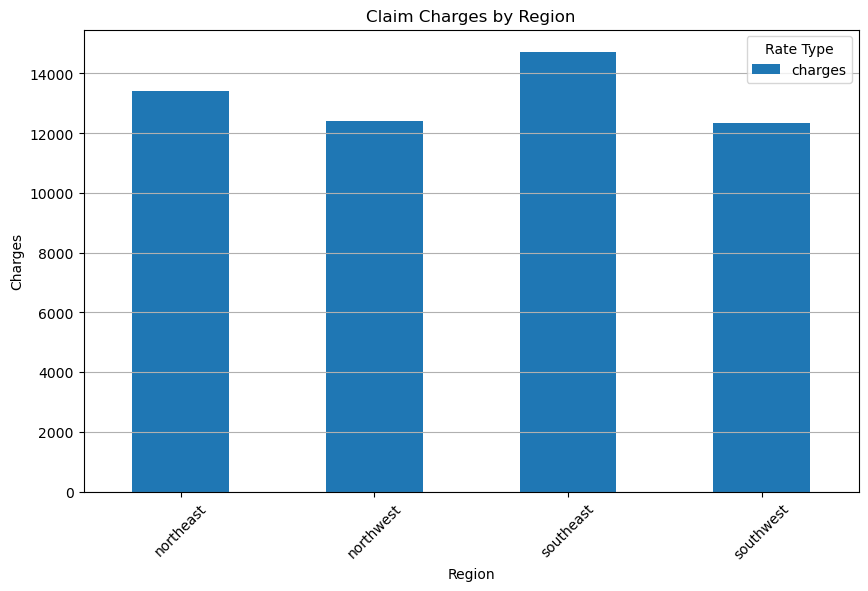

In [34]:
# Visualize Results 
plt.figure(figsize=(10, 6)) 
region_claim_charges.set_index('region').plot(kind='bar', figsize=(10, 6)) 
plt.xlabel('Region') 
plt.ylabel('Charges') 
plt.title('Claim Charges by Region') 
plt.legend(title='Rate Type') 
plt.xticks(rotation=45) 
plt.grid(axis='y')

In [35]:
## 3.	What is the impact of smoking status and BMI on claim charges or denial rates?

In [36]:
# Group by smoking status and calculate average by claim charges
smoking_claim_charges = insurance_df.groupby('smoker')['charges'].mean().reset_index()
print('Average Claim Chaarges by Smoking Status:')
print(smoking_claim_charges)

Average Claim Chaarges by Smoking Status:
  smoker       charges
0     no   8434.268298
1    yes  32050.231832


/var/folders/cg/5nkbpx6j5r1brtzy2mxr3ms00000gn/T/ipykernel_25666/2490631551.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='smoker', y='charges', data=smoking_claim_charges, palette='viridis')


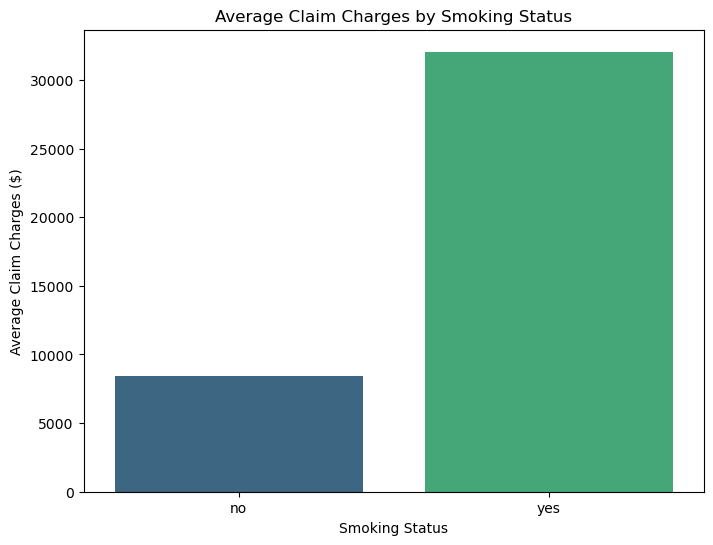

In [37]:
# Visualize Results 
plt.figure(figsize=(8,6))
sns.barplot(x='smoker', y='charges', data=smoking_claim_charges, palette='viridis')
plt.title('Average Claim Charges by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Average Claim Charges ($)')
plt.show()

Average Claim Charges by BMI Category:
  bmi_category       charges
0  Underweight   8657.620652
1       Normal  10404.900084
2   Overweight  11006.809989
3        Obese  15491.542238


/var/folders/cg/5nkbpx6j5r1brtzy2mxr3ms00000gn/T/ipykernel_25666/282402654.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_claim_charges = insurance_df.groupby('bmi_category')['charges'].mean().reset_index()
/var/folders/cg/5nkbpx6j5r1brtzy2mxr3ms00000gn/T/ipykernel_25666/282402654.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bmi_category', y='charges', data=bmi_claim_charges, palette='viridis')


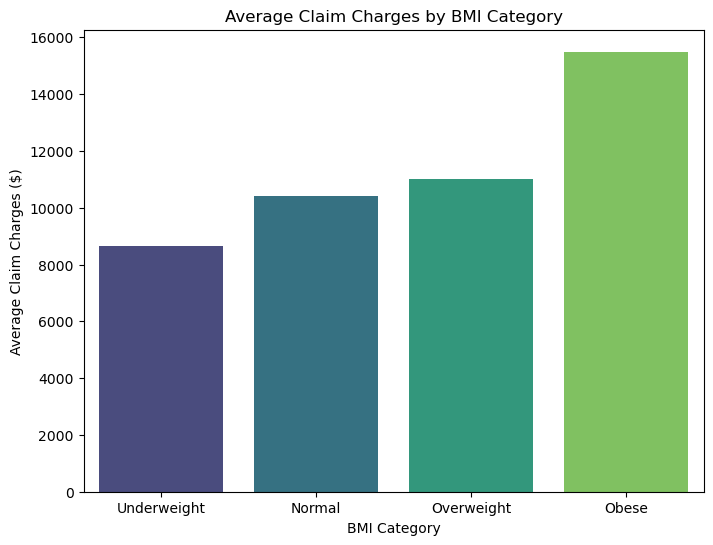

In [38]:
# Create BMI categories 
insurance_df['bmi_category'] = pd.cut(insurance_df['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], 
                                      labels=['Underweight', 'Normal', 'Overweight', 'Obese']) 

# Group by BMI category and calculate average claim charges 
bmi_claim_charges = insurance_df.groupby('bmi_category')['charges'].mean().reset_index() 
print("Average Claim Charges by BMI Category:") 
print(bmi_claim_charges) 

# Visualize the results 
plt.figure(figsize=(8, 6)) 
sns.barplot(x='bmi_category', y='charges', data=bmi_claim_charges, palette='viridis') 
plt.title('Average Claim Charges by BMI Category') 
plt.xlabel('BMI Category') 
plt.ylabel('Average Claim Charges ($)') 
plt.show()

In [39]:
# Group by region and smoking status and calculate mean charges 
smoking_region_charges = insurance_df.groupby(['region', 'smoker'])['charges'].mean().reset_index()

# Group by region and smoking status and calculate mean charges
insurance_df['BMI_Category'] = pd.cut(insurance_df['bmi'], bins=[0,18.5, 25, 30, np.inf],
                                      labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
bmi_region_charges = insurance_df.groupby(['region', 'BMI_Category'])['charges'].mean().reset_index()

/var/folders/cg/5nkbpx6j5r1brtzy2mxr3ms00000gn/T/ipykernel_25666/3242606507.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_region_charges = insurance_df.groupby(['region', 'BMI_Category'])['charges'].mean().reset_index()


In [40]:
## 4.	Which states or regions have the highest claim charges and denial rates, and what demographic factors contributes to this?

In [41]:
# Example: Analyze demographic factors for the top region (e.g., Southeast) 
top_region = region_claim_charges.iloc[0]['region'] 
top_region_data = insurance_df[insurance_df['region'] == top_region] 

# Group by demographic factors and calculate average claim charges 
demographic_analysis = top_region_data.groupby(['sex', 'smoker', 'bmi_category'])['charges'].mean().unstack() 
print("Demographic Analysis for Top Region (Claim Charges):") 
print(demographic_analysis)

Demographic Analysis for Top Region (Claim Charges):
bmi_category    Underweight        Normal    Overweight         Obese
sex    smoker                                                        
female no       6745.586675   9018.166884   8412.415992  10696.225618
       yes     14731.111750  18646.801563  23464.848780  44238.125938
male   no       6623.404633   7158.961034   8636.641828   9686.900175
       yes     12829.455100  21628.914174  23390.456408  38853.058988


/var/folders/cg/5nkbpx6j5r1brtzy2mxr3ms00000gn/T/ipykernel_25666/2741210702.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demographic_analysis = top_region_data.groupby(['sex', 'smoker', 'bmi_category'])['charges'].mean().unstack()


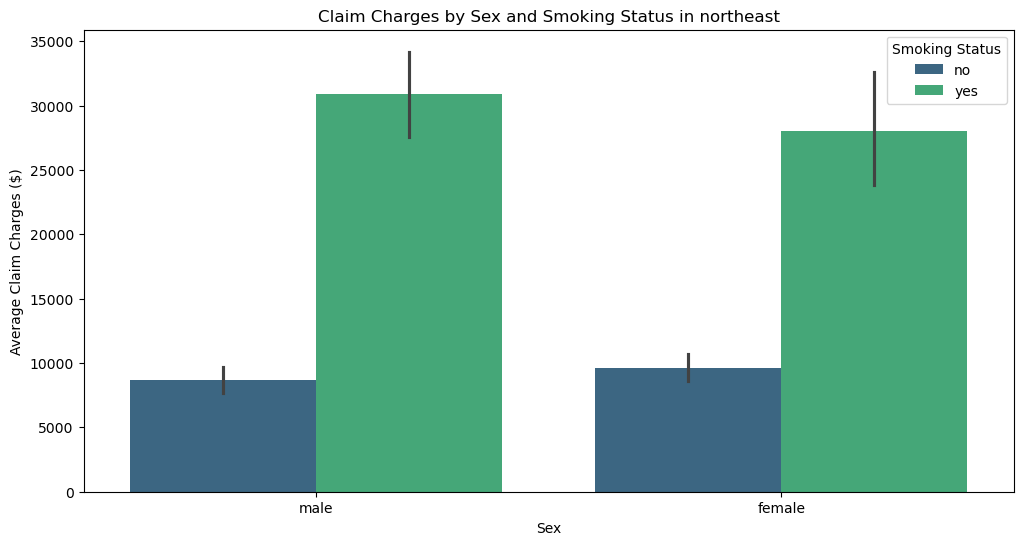

/var/folders/cg/5nkbpx6j5r1brtzy2mxr3ms00000gn/T/ipykernel_25666/3454028370.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bmi_category', y='charges', data=top_region_data, palette='viridis')


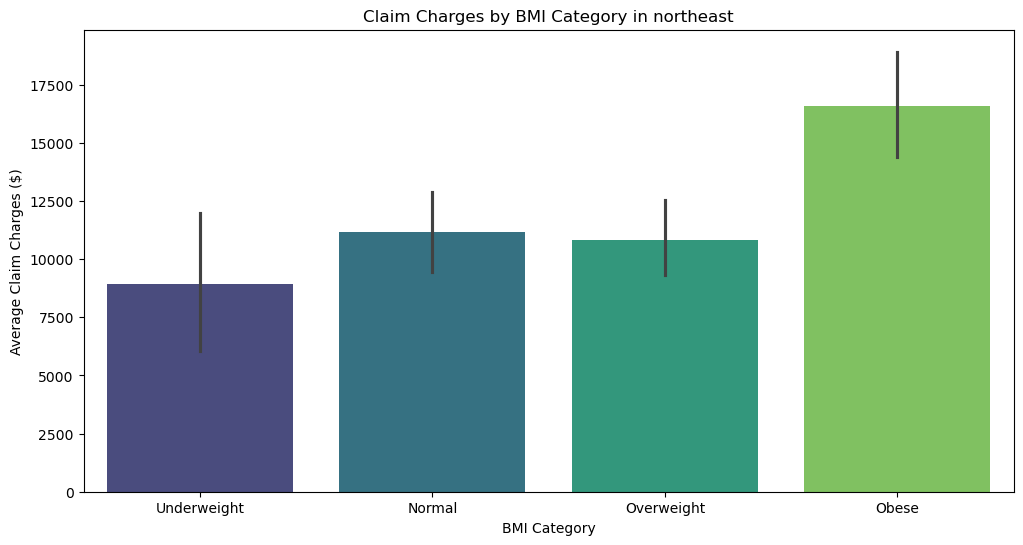

In [42]:
# Visualize claim charges by sex and smoking status 
plt.figure(figsize=(12, 6)) 
sns.barplot(x='sex', y='charges', hue='smoker', data=top_region_data, palette='viridis') 
plt.title(f'Claim Charges by Sex and Smoking Status in {top_region}') 
plt.xlabel('Sex') 
plt.ylabel('Average Claim Charges ($)') 
plt.legend(title='Smoking Status') 
plt.show() 

# Visualize claim charges by BMI category 
plt.figure(figsize=(12, 6)) 
sns.barplot(x='bmi_category', y='charges', data=top_region_data, palette='viridis') 
plt.title(f'Claim Charges by BMI Category in {top_region}') 
plt.xlabel('BMI Category') 
plt.ylabel('Average Claim Charges ($)') 
plt.show()

In [43]:
## 5.	Which state or region has the highest rate of appeals and appeals overturned? 

In [44]:
# Select the 10 states with the highest Internal Appeals Rate
top_appeal_states = cms_df[['State', 'Internal_Appeals_Rate']].nlargest(10, 'Internal_Appeals_Rate')

# Display top states
print(top_appeal_states)

    State  Internal_Appeals_Rate
126    TX                  0.235
30     GA                  0.209
108    OR                  0.090
107    OR                  0.085
116    TN                  0.045
33     HI                  0.042
75     MT                  0.042
11     AZ                  0.038
76     MT                  0.036
140    VA                  0.033


In [45]:
# Select top 10 states with the highest Internal Appeals Overturn Rate
top_overturn_states = cms_df[['State', 'Internal_Appeals_Overturn_Rate']].nlargest(10, 'Internal_Appeals_Overturn_Rate')

# Display top states
print(top_overturn_states)

    State  Internal_Appeals_Overturn_Rate
53     LA                           4.380
94     OH                           0.967
96     OH                           0.958
13     AZ                           0.944
123    TX                           0.884
63     MI                           0.881
62     MI                           0.875
18     FL                           0.841
125    TX                           0.836
4      AR                           0.835


/var/folders/cg/5nkbpx6j5r1brtzy2mxr3ms00000gn/T/ipykernel_25666/3135872212.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Internal_Appeals_Rate', y='State', data=top_appeal_states, palette='Blues_r')


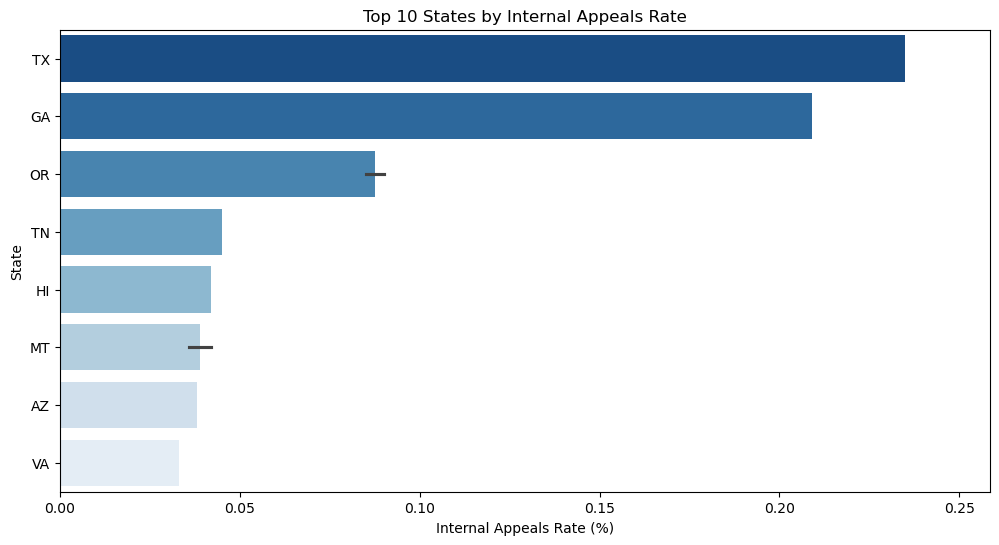

In [46]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Internal_Appeals_Rate', y='State', data=top_appeal_states, palette='Blues_r')

plt.title('Top 10 States by Internal Appeals Rate')
plt.xlabel('Internal Appeals Rate (%)')
plt.ylabel('State')
plt.xlim(0, max(top_appeal_states['Internal_Appeals_Rate']) * 1.1)  # Adjust x-axis limit
plt.show()

/var/folders/cg/5nkbpx6j5r1brtzy2mxr3ms00000gn/T/ipykernel_25666/60890346.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Internal_Appeals_Overturn_Rate', y='State', data=top_overturn_states, palette='Reds_r')


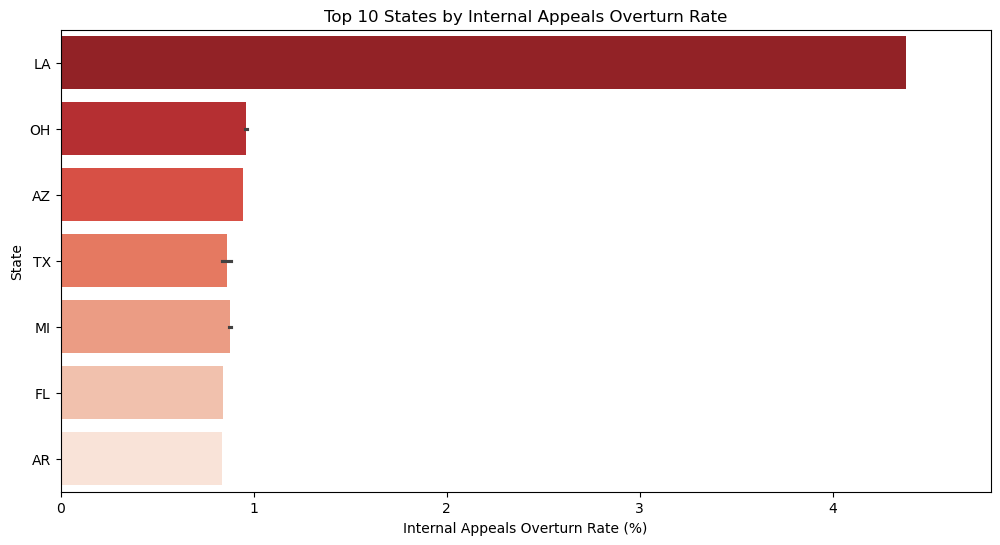

In [47]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Internal_Appeals_Overturn_Rate', y='State', data=top_overturn_states, palette='Reds_r')

plt.title('Top 10 States by Internal Appeals Overturn Rate')
plt.xlabel('Internal Appeals Overturn Rate (%)')
plt.ylabel('State')
plt.xlim(0, max(top_overturn_states['Internal_Appeals_Overturn_Rate']) * 1.1)  # Adjust x-axis limit
plt.show()

In [48]:
# Close connection 
conn.close()

In [49]:
# Convert the DataFrame to JSON 
insurance_df.to_json("Resources/insurance.json", orient="records")

In [50]:
# Convert DataFrame to JSON string 
json_data = insurance_df.to_json(orient="records") 

# Pretty-print the JSON 
parsed = json.loads(json_data) 
print(json.dumps(parsed, indent=4))  # Display formatted JSON

[
    {
        "age": 19,
        "sex": "female",
        "bmi": 27.9,
        "children": 0,
        "smoker": "yes",
        "region": "southwest",
        "charges": 16884.924,
        "bmi_category": "Overweight",
        "BMI_Category": "Overweight"
    },
    {
        "age": 18,
        "sex": "male",
        "bmi": 33.77,
        "children": 1,
        "smoker": "no",
        "region": "southeast",
        "charges": 1725.5523,
        "bmi_category": "Obese",
        "BMI_Category": "Obese"
    },
    {
        "age": 28,
        "sex": "male",
        "bmi": 33.0,
        "children": 3,
        "smoker": "no",
        "region": "southeast",
        "charges": 4449.462,
        "bmi_category": "Obese",
        "BMI_Category": "Obese"
    },
    {
        "age": 33,
        "sex": "male",
        "bmi": 22.705,
        "children": 0,
        "smoker": "no",
        "region": "northwest",
        "charges": 21984.47061,
        "bmi_category": "Normal",
        "BMI_Category":